## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"

!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.1 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install triton==2.2.0 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 10.0 MB/s eta 0:00:00:00:0100:01


In [3]:

!pip install causal_conv1d

  Preparing metadata (setup.py) ... done
  Created wheel for causal_conv1d: filename=causal_conv1d-1.5.0.post8-cp310-cp310-linux_x86_64.whl size=103955196 sha256=0ca2375ba7fb0c5022696dc3086c284e0eb1a7b33cf57aced23ec726c3d2b0a5
  Stored in directory: /root/.cache/pip/wheels/75/ef/0a/d9abf869acdd5fc07f403f4d8dd9db650cd66e81528a907941
Successfully built causal_conv1d


In [4]:
!pip install mamba_ssm==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for mamba_ssm: filename=mamba_ssm-2.2.2-cp310-cp310-linux_x86_64.whl size=323988104 sha256=6b082468a6abb6f6bc50c99263f17c6c7f5a2e8f6b275ed7998b81fb25279229
  Stored in directory: /root/.cache/pip/wheels/57/7c/90/9f963468ecc3791e36e388f9e7b4a4e1e3f90fbb340055aa4d
Successfully built mamba_ssm


## Setup imports

In [5]:
from __future__ import annotations
import torch.nn as nn
import torch 
from functools import partial
import glob
import json
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import torch.nn.functional as F 
from torchinfo import summary

In [6]:
import mamba_ssm

/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

In [7]:
from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.blocks.unetr_block import UnetrBasicBlock, UnetrUpBlock
from monai.data import DataLoader, decollate_batch, Dataset
from monai.config import print_config
from monai.losses import DiceCELoss, DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    CropForegroundd,
    Resized,
    SpatialPadd,
    CenterSpatialCropd,
    RandAffined,
    RandGaussianNoised,
    RandAdjustContrastd
)

from monai.utils import set_determinism

print_config()

MONAI version: 1.5.dev2452
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 889d81d09ea262ecaea1104224473012cab33a42
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.4
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

## Setup data directory

In [8]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")

if directory is not None:

    os.makedirs(directory, exist_ok=True)

root_dir = tempfile.mkdtemp() if directory is None else directory

print(root_dir)

/tmp/tmpc34h5app


## Setup average meter, fold reader, checkpoint saver

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

## Setup dataloader

In [10]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is NETC
    label 2 is SNFH
    label 3 is ET
    label 4 is RC
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(torch.logical_or(d[key] == 1, d[key] == 3))
            result.append(torch.logical_or(torch.logical_or(d[key] == 1, d[key] == 3), d[key] == 2))
            result.append(d[key] == 3)
            result.append(d[key] == 4)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [11]:
!pip install huggingface_hub

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [12]:
# Copyright (c) 2024, Tri Dao, Albert Gu.

"""We want triton==2.1.0 or 2.2.0 for this
"""

from typing import Optional

import math
from packaging import version

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.cuda.amp import custom_bwd, custom_fwd
import causal_conv1d_cuda
import selective_scan_cuda

import triton
import triton.language as tl

from einops import rearrange, repeat

try:
    from causal_conv1d import causal_conv1d_fn
    import causal_conv1d_cuda
except ImportError:
    causal_conv1d_fn, causal_conv1d_cuda = None, None

from mamba_ssm.ops.triton.ssd_bmm import _bmm_chunk_fwd, _bmm_chunk_bwd
from mamba_ssm.ops.triton.ssd_chunk_state import _chunk_cumsum_fwd, _chunk_cumsum_bwd
from mamba_ssm.ops.triton.ssd_chunk_state import _chunk_state_fwd, _chunk_state_bwd_db
from mamba_ssm.ops.triton.ssd_chunk_state import _chunk_state_bwd_ddAcs_stable
from mamba_ssm.ops.triton.ssd_chunk_state import chunk_state, chunk_state_ref
from mamba_ssm.ops.triton.ssd_chunk_state import chunk_state_varlen
from mamba_ssm.ops.triton.ssd_state_passing import _state_passing_fwd, _state_passing_bwd
from mamba_ssm.ops.triton.ssd_state_passing import state_passing, state_passing_ref
from mamba_ssm.ops.triton.ssd_chunk_scan import _chunk_scan_fwd, _chunk_scan_bwd_dz, _chunk_scan_bwd_dstates
from mamba_ssm.ops.triton.ssd_chunk_scan import _chunk_scan_bwd_dC, _chunk_scan_bwd_dcb
from mamba_ssm.ops.triton.ssd_chunk_scan import _chunk_scan_bwd_ddAcs_stable
from mamba_ssm.ops.triton.ssd_chunk_scan import chunk_scan, chunk_scan_ref
from mamba_ssm.ops.triton.ssd_chunk_scan import _chunk_scan_bwd_ddAcs_prev
from mamba_ssm.ops.triton.layernorm_gated import rmsnorm_fn, _layer_norm_fwd, _layer_norm_bwd
from mamba_ssm.ops.triton.k_activations import _swiglu_fwd, _swiglu_bwd

TRITON_22 = version.parse(triton.__version__) >= version.parse('2.2.0')


def init_to_zero(names):
    return lambda nargs: [nargs[name].zero_() for name in names if nargs[name] is not None]


@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64}, num_stages=3, num_warps=8, pre_hook=init_to_zero(["ddt_ptr"])),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4, pre_hook=init_to_zero(["ddt_ptr"])),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4, pre_hook=init_to_zero(["ddt_ptr"])),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4, pre_hook=init_to_zero(["ddt_ptr"])),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4, pre_hook=init_to_zero(["ddt_ptr"])),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4, pre_hook=init_to_zero(["ddt_ptr"])),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32}, num_stages=5, num_warps=4, pre_hook=init_to_zero(["ddt_ptr"])),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=5, num_warps=4, pre_hook=init_to_zero(["ddt_ptr"])),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4, pre_hook=init_to_zero(["ddt_ptr"])),
    ],
    key=['chunk_size', 'hdim', 'dstate'],
)
@triton.jit
def _chunk_scan_chunk_state_bwd_dx_kernel(
    # Pointers to matrices
    x_ptr, cb_ptr, dout_ptr, dt_ptr, dA_cumsum_ptr, seq_idx_ptr, D_ptr,
    b_ptr, dstates_ptr,
    dx_ptr, ddt_ptr, dD_ptr,
    # Matrix dimensions
    chunk_size, hdim, dstate,
    batch, seqlen, nheads_ngroups_ratio,
    # Strides
    stride_x_batch, stride_x_seqlen, stride_x_head, stride_x_hdim,
    stride_cb_batch, stride_cb_chunk, stride_cb_head, stride_cb_csize_m, stride_cb_csize_k,
    stride_dout_batch, stride_dout_seqlen, stride_dout_head, stride_dout_hdim,
    stride_dt_batch, stride_dt_chunk, stride_dt_head, stride_dt_csize,
    stride_dA_cs_batch, stride_dA_cs_chunk, stride_dA_cs_head, stride_dA_cs_csize,
    stride_seq_idx_batch, stride_seq_idx_seqlen,
    stride_D_head,
    stride_b_batch, stride_b_seqlen, stride_b_head, stride_b_dstate,
    stride_dstates_batch, stride_dstates_chunk, stride_dstates_head, stride_dstates_hdim, stride_dstates_dstate,
    stride_dx_batch, stride_dx_seqlen, stride_dx_head, stride_dx_hdim,
    stride_ddt_batch, stride_ddt_chunk, stride_ddt_head, stride_ddt_csize,
    stride_dD_batch, stride_dD_chunk, stride_dD_head, stride_dD_csize, stride_dD_hdim,
    # Meta-parameters
    HAS_D: tl.constexpr,
    D_HAS_HDIM: tl.constexpr,
    HAS_SEQ_IDX: tl.constexpr,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    BLOCK_SIZE_DSTATE: tl.constexpr,
    IS_TRITON_22: tl.constexpr,
):
    pid_bc = tl.program_id(axis=1)
    pid_c = pid_bc // batch
    pid_b = pid_bc - pid_c * batch
    pid_h = tl.program_id(axis=2)
    num_pid_n = tl.cdiv(hdim, BLOCK_SIZE_N)
    pid_m = tl.program_id(axis=0) // num_pid_n
    pid_n = tl.program_id(axis=0) % num_pid_n
    x_ptr += pid_b * stride_x_batch + pid_c * chunk_size * stride_x_seqlen + pid_h * stride_x_head
    cb_ptr += pid_b * stride_cb_batch + pid_c * stride_cb_chunk + (pid_h // nheads_ngroups_ratio) * stride_cb_head
    dout_ptr += pid_b * stride_dout_batch + pid_c * chunk_size * stride_dout_seqlen + pid_h * stride_dout_head
    dt_ptr += pid_b * stride_dt_batch + pid_c * stride_dt_chunk + pid_h * stride_dt_head
    ddt_ptr += pid_b * stride_ddt_batch + pid_c * stride_ddt_chunk + pid_h * stride_ddt_head
    dA_cumsum_ptr += pid_b * stride_dA_cs_batch + pid_c * stride_dA_cs_chunk + pid_h * stride_dA_cs_head
    b_ptr += pid_b * stride_b_batch + pid_c * chunk_size * stride_b_seqlen + (pid_h // nheads_ngroups_ratio) * stride_b_head
    dstates_ptr += pid_b * stride_dstates_batch + pid_c * stride_dstates_chunk + pid_h * stride_dstates_head
    if HAS_SEQ_IDX:
        seq_idx_ptr += pid_b * stride_seq_idx_batch + pid_c * chunk_size * stride_seq_idx_seqlen

    offs_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_n = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)

    chunk_size_limit = min(chunk_size, seqlen - pid_c * chunk_size)

    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    dA_cs_m = tl.load(dA_cumsum_ptr + offs_m * stride_dA_cs_csize, mask=offs_m < chunk_size_limit, other=0.0).to(tl.float32)

    dA_cs_last = tl.load(dA_cumsum_ptr + (chunk_size - 1) * stride_dA_cs_csize).to(tl.float32)
    if not HAS_SEQ_IDX:
        scale = tl.exp(dA_cs_last - dA_cs_m)
    else:
        seq_idx_m = tl.load(seq_idx_ptr + offs_m * stride_seq_idx_seqlen, mask=offs_m < chunk_size_limit, other=-1)
        seq_idx_last = tl.load(seq_idx_ptr + (chunk_size_limit - 1) * stride_seq_idx_seqlen)
        scale = tl.where(seq_idx_m == seq_idx_last, tl.exp(dA_cs_last - dA_cs_m), 0.0)
    # Might be faster to just do 1 iteration with larger BLOCK_SIZE_K, up to block size 128
    # However, we're getting error with the Triton compiler 2.1.0 for that code path:
    # Unexpected mma -> mma layout conversion
    # Triton 2.2.0 fixes this
    offs_dstate = tl.arange(0, BLOCK_SIZE_DSTATE if IS_TRITON_22 and BLOCK_SIZE_DSTATE <= 128 else BLOCK_SIZE_K)
    b_ptrs = b_ptr + (offs_m[:, None] * stride_b_seqlen + offs_dstate[None, :] * stride_b_dstate)
    dstates_ptrs = dstates_ptr + (offs_n[None, :] * stride_dstates_hdim + offs_dstate[:, None] * stride_dstates_dstate)
    if IS_TRITON_22 and BLOCK_SIZE_DSTATE <= 128:
        b = tl.load(b_ptrs, mask=(offs_m[:, None] < chunk_size_limit) & (offs_dstate[None, :] < dstate), other=0.0)
        dstates = tl.load(dstates_ptrs, mask=(offs_dstate[:, None] < dstate) & (offs_n[None, :] < hdim), other=0.0)
        dstates = dstates.to(b_ptr.dtype.element_ty)
        acc = tl.dot(b, dstates) * scale[:, None]
    else:
        for k in range(0, dstate, BLOCK_SIZE_K):
            b = tl.load(b_ptrs, mask=(offs_m[:, None] < chunk_size_limit) & (offs_dstate[None, :] < dstate - k), other=0.0)
            dstates = tl.load(dstates_ptrs, mask=(offs_dstate[:, None] < dstate - k) & (offs_n[None, :] < hdim), other=0.0)
            dstates = dstates.to(b_ptr.dtype.element_ty)
            acc += tl.dot(b, dstates)
            b_ptrs += BLOCK_SIZE_K * stride_b_dstate
            dstates_ptrs += BLOCK_SIZE_K * stride_dstates_dstate
        acc *= scale[:, None]

    # x_ptrs = x_ptr + (offs_m[:, None] * stride_x_seqlen + offs_n[None, :] * stride_x_hdim)
    # x = tl.load(x_ptrs, mask=(offs_m[:, None] < chunk_size_limit) & (offs_n[None, :] < hdim), other=0.0).to(tl.float32)
    # dt_ptrs = dt_ptr + offs_m * stride_dt_csize
    # dt_m = tl.load(dt_ptrs, mask=offs_m < chunk_size_limit, other=0.0).to(tl.float32)
    # ddt = tl.sum(acc * x, axis=1) * dt_m
    # ddt_ptrs = ddt_ptr + offs_m * stride_ddt_csize
    # tl.atomic_add(ddt_ptrs, ddt, mask=offs_m < chunk_size)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    cb_ptrs = cb_ptr + (offs_m[:, None] * stride_cb_csize_m + offs_k[None, :] * stride_cb_csize_k)
    dout_ptrs = dout_ptr + (offs_k[:, None] * stride_dout_seqlen + offs_n[None, :] * stride_dout_hdim)
    dA_cumsum_ptrs = dA_cumsum_ptr + offs_k * stride_dA_cs_csize
    K_MAX = chunk_size_limit
    K_MIN = pid_m * BLOCK_SIZE_M
    cb_ptrs += K_MIN * stride_cb_csize_k
    dout_ptrs += K_MIN * stride_dout_seqlen
    dA_cumsum_ptrs += K_MIN * stride_dA_cs_csize
    for k in range(K_MIN, K_MAX, BLOCK_SIZE_K):
        k = tl.multiple_of(k, BLOCK_SIZE_K)
        # For some reason setting mask to (offs_m[:, None] < chunk_size_limit) is much slower
        cb = tl.load(cb_ptrs, mask=(offs_m[:, None] < chunk_size) & (offs_k[None, :] < K_MAX - k), other=0.0)
        dout = tl.load(dout_ptrs, mask=(offs_k[:, None] < K_MAX - k) & (offs_n[None, :] < hdim), other=0.0)
        dA_cs_k = tl.load(dA_cumsum_ptrs, mask=offs_k < K_MAX - k, other=0.0).to(tl.float32)
        cb *= tl.exp(dA_cs_k[None, :] - dA_cs_m[:, None])
        # If we don't have the (k + offs_k[None, :] < K_MAX) mask, for indices outside this range,
        # we might have dA_cs_m = 0.0 and dA_cs_k very negative, and tl.exp will return inf.
        # Multiplying with cb, which is 0.0 outside the range, will make the result NaN.
        # This will cause NaN in acc, and hence NaN in dx and ddt.
        mask = (k + offs_k[None, :] >= offs_m[:, None]) & (k + offs_k[None, :] < K_MAX)
        cb = tl.where(mask, cb, 0.0)
        cb = cb.to(dout_ptr.dtype.element_ty)
        acc += tl.dot(cb, dout)
        cb_ptrs += BLOCK_SIZE_K * stride_cb_csize_k
        dout_ptrs += BLOCK_SIZE_K * stride_dout_seqlen
        dA_cumsum_ptrs += BLOCK_SIZE_K * stride_dA_cs_csize

    offs_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_n = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    dt_ptrs = dt_ptr + offs_m * stride_dt_csize
    dt_m = tl.load(dt_ptrs, mask=offs_m < chunk_size_limit, other=0.0).to(tl.float32)
    dx = acc * dt_m[:, None]
    dx_ptr += pid_b * stride_dx_batch + pid_c * chunk_size * stride_dx_seqlen + pid_h * stride_dx_head
    dx_ptrs = dx_ptr + (offs_m[:, None] * stride_dx_seqlen + offs_n[None, :] * stride_dx_hdim)
    if HAS_D:
        dout_res_ptrs = dout_ptr + (offs_m[:, None] * stride_dout_seqlen + offs_n[None, :] * stride_dout_hdim)
        dout_res = tl.load(dout_res_ptrs, mask=(offs_m[:, None] < chunk_size_limit) & (offs_n[None, :] < hdim), other=0.0).to(tl.float32)
        if D_HAS_HDIM:
            D = tl.load(D_ptr + pid_h * stride_D_head + offs_n, mask=offs_n < hdim, other=0.0).to(tl.float32)
        else:
            D = tl.load(D_ptr + pid_h * stride_D_head).to(tl.float32)
        dx += dout_res * D
    tl.store(dx_ptrs, dx, mask=(offs_m[:, None] < chunk_size_limit) & (offs_n[None, :] < hdim))

    x_ptrs = x_ptr + (offs_m[:, None] * stride_x_seqlen + offs_n[None, :] * stride_x_hdim)
    x = tl.load(x_ptrs, mask=(offs_m[:, None] < chunk_size_limit) & (offs_n[None, :] < hdim), other=0.0).to(tl.float32)
    if HAS_D:
        dD_ptr += pid_b * stride_dD_batch + pid_c * stride_dD_chunk + pid_h * stride_dD_head + pid_m * stride_dD_csize
        if D_HAS_HDIM:
            dD_ptrs = dD_ptr + offs_n * stride_dD_hdim
            dD = tl.sum(dout_res * x, axis=0)
            tl.store(dD_ptrs, dD, mask=offs_n < hdim)
        else:
            dD = tl.sum(dout_res * x)
            tl.store(dD_ptr, dD)
    ddt = tl.sum(acc * x, axis=1)
    ddt_ptrs = ddt_ptr + offs_m * stride_ddt_csize
    tl.atomic_add(ddt_ptrs, ddt, mask=offs_m < chunk_size)


def _chunk_scan_chunk_state_bwd_dx(x, dt, dA_cumsum, B, CB, dout, dstates, D=None, seq_idx=None, dx=None):
    batch, seqlen, nheads, headdim = x.shape
    _, _, nchunks, chunk_size = dt.shape
    _, _, ngroups, dstate = B.shape
    assert nheads % ngroups == 0
    assert B.shape == (batch, seqlen, ngroups, dstate)
    assert CB.shape == (batch, nchunks, ngroups, chunk_size, chunk_size)
    assert dt.shape == (batch, nheads, nchunks, chunk_size)
    assert dA_cumsum.shape == dt.shape
    assert dout.shape == x.shape
    assert dstates.shape == (batch, nchunks, nheads, headdim, dstate)
    if seq_idx is not None:
        assert seq_idx.shape == (batch, seqlen)
    if D is not None:
        assert D.shape == (nheads, headdim) or D.shape == (nheads,)
        assert D.stride(-1) == 1
        BLOCK_SIZE_min = 32
        dD = torch.empty(triton.cdiv(chunk_size, BLOCK_SIZE_min), batch, nchunks, nheads,
                         headdim if D.dim() == 2 else 1, device=D.device, dtype=torch.float32)
    else:
        dD = None
    dD_strides = ((dD.stride(0), dD.stride(1), dD.stride(2), dD.stride(3), dD.stride(4))
                    if D is not None else (0, 0, 0, 0, 0))
    if dx is None:
        dx = torch.empty_like(x)
    else:
        assert dx.shape == x.shape
    ddt = torch.empty(batch, nheads, nchunks, chunk_size, device=dout.device, dtype=torch.float32)
    grid_dx = lambda META: (triton.cdiv(chunk_size, META['BLOCK_SIZE_M']) * triton.cdiv(headdim, META['BLOCK_SIZE_N']),
                        batch * nchunks, nheads)
    with torch.cuda.device(x.device.index):
        _chunk_scan_chunk_state_bwd_dx_kernel[grid_dx](
            x, CB, dout, dt, dA_cumsum, seq_idx, D, B, dstates, dx, ddt, dD,
            chunk_size, headdim, dstate,
            batch, seqlen, nheads // ngroups,
            x.stride(0), x.stride(1), x.stride(2), x.stride(3),
            CB.stride(0), CB.stride(1), CB.stride(2), CB.stride(-1), CB.stride(-2),
            dout.stride(0), dout.stride(1), dout.stride(2), dout.stride(3),
            dt.stride(0), dt.stride(2), dt.stride(1), dt.stride(3),
            dA_cumsum.stride(0), dA_cumsum.stride(2), dA_cumsum.stride(1), dA_cumsum.stride(3),
            *((seq_idx.stride(0), seq_idx.stride(1)) if seq_idx is not None else (0, 0)),
            D.stride(0) if D is not None else 0,
            B.stride(0), B.stride(1), B.stride(2), B.stride(3),
            dstates.stride(0), dstates.stride(1), dstates.stride(2), dstates.stride(3), dstates.stride(4),
            dx.stride(0), dx.stride(1), dx.stride(2), dx.stride(3),
            ddt.stride(0), ddt.stride(2), ddt.stride(1), ddt.stride(3),
            dD_strides[1], dD_strides[2], dD_strides[3], dD_strides[0], dD_strides[4],
            D is not None,
            D.dim() == 2 if D is not None else True,
            HAS_SEQ_IDX=seq_idx is not None,
            BLOCK_SIZE_DSTATE=max(triton.next_power_of_2(dstate), 16),
            IS_TRITON_22=TRITON_22
        )
    if D is not None:
        BLOCK_SIZE_actual = _chunk_scan_chunk_state_bwd_dx_kernel.best_config.kwargs["BLOCK_SIZE_M"]
        n_valid_blocks = (chunk_size + BLOCK_SIZE_actual - 1) // BLOCK_SIZE_actual
        dD = dD[:n_valid_blocks].sum(dim=(0, 1, 2)).to(dtype=D.dtype)
        if D.dim() == 1:
            dD = rearrange(dD, "h 1 -> h")
    return dx, ddt.to(dtype=dt.dtype), dD


def _mamba_chunk_scan_combined_fwd(x, dt, A, B, C, chunk_size, D=None, z=None, dt_bias=None, initial_states=None, seq_idx=None, cu_seqlens=None, dt_softplus=False, dt_limit=(0.0, float("inf"))):
    batch, seqlen, nheads, headdim = x.shape
    _, _, ngroups, dstate = B.shape
    assert nheads % ngroups == 0
    assert B.shape == (batch, seqlen, ngroups, dstate)
    assert x.shape == (batch, seqlen, nheads, headdim)
    assert dt.shape == (batch, seqlen, nheads)
    assert A.shape == (nheads,)
    assert C.shape == B.shape
    if z is not None:
        assert z.shape == x.shape
    if D is not None:
        assert D.shape == (nheads, headdim) or D.shape == (nheads,)
    if seq_idx is not None:
        assert seq_idx.shape == (batch, seqlen)
    if B.stride(-1) != 1:
        B = B.contiguous()
    if C.stride(-1) != 1:
        C = C.contiguous()
    if x.stride(-1) != 1 and x.stride(1) != 1:  # Either M or K dimension should be contiguous
        x = x.contiguous()
    if z is not None and z.stride(-1) != 1 and z.stride(1) != 1:  # Either M or K dimension should be contiguous
        z = z.contiguous()
    if D is not None and D.stride(-1) != 1:
        D = D.contiguous()
    if initial_states is not None:
        assert initial_states.shape == (batch, nheads, headdim, dstate)
    # # (batch, nchunks, chunk_size, chunk_size) or (batch, nchunks, nheads, chunk_size, chunk_size)
    # dA_cumsum_tmp0, dt_tmp0 = _chunk_cumsum_fwd(dt[:, :147], A, chunk_size, dt_bias=dt_bias, dt_softplus=dt_softplus)
    # dA_cumsum_tmp1, dt_tmp1 = _chunk_cumsum_fwd(dt[:, 147:], A, chunk_size, dt_bias=dt_bias, dt_softplus=dt_softplus)
    # dA_cumsum_tmp2, dt_tmp2 = _chunk_cumsum_fwd(dt[:, 147:256], A, chunk_size, dt_bias=dt_bias, dt_softplus=dt_softplus)
    dA_cumsum, dt = _chunk_cumsum_fwd(dt, A, chunk_size, dt_bias=dt_bias, dt_softplus=dt_softplus, dt_limit=dt_limit)
    states = _chunk_state_fwd(B, x, dt, dA_cumsum, seq_idx=seq_idx, states_in_fp32=True)
    # states_tmp0 = _chunk_state_fwd(B[:, :147], x[:, :147], dt_tmp0, dA_cumsum_tmp0, states_in_fp32=True)
    # states_tmp1 = _chunk_state_fwd(B[:, 147:], x[:, 147:], dt_tmp1, dA_cumsum_tmp1, states_in_fp32=True)
    # states_tmp2 = _chunk_state_fwd(B[:, 147:256], x[:, 147:256], dt_tmp2, dA_cumsum_tmp2, states_in_fp32=True)
    states, final_states = _state_passing_fwd(rearrange(states, "... p n -> ... (p n)"), dA_cumsum[:, :, :, -1],
                                              initial_states=rearrange(initial_states, "... p n -> ... (p n)") if initial_states is not None else None,
                                              seq_idx=seq_idx, chunk_size=chunk_size, out_dtype=C.dtype)
    states, final_states = [rearrange(t, "... (p n) -> ... p n", n=dstate) for t in [states, final_states]]
    # states_tmp0 = rearrange(_state_passing_fwd(rearrange(states_tmp0, "... p n -> ... (p n)"), dA_cumsum_tmp0[:, :, :, -1], chunk_size=chunk_size), "... (p n) -> ... p n", n=dstate)
    # states_tmp1 = rearrange(_state_passing_fwd(rearrange(states_tmp1, "... p n -> ... (p n)"), dA_cumsum_tmp1[:, :, :, -1], chunk_size=chunk_size), "... (p n) -> ... p n", n=dstate)
    CB = _bmm_chunk_fwd(C, B, chunk_size, seq_idx=seq_idx, output_dtype=torch.float32)
    out, out_x = _chunk_scan_fwd(CB, x, dt, dA_cumsum, C, states, D=D, z=z, seq_idx=seq_idx)
    if cu_seqlens is None:
        return out, out_x, dt, dA_cumsum, states, final_states
    else:
        assert batch == 1, "passing cu_seqlens to get the varlen states is only supported if batch dimension is 1"
        varlen_states = chunk_state_varlen(B.squeeze(0), x.squeeze(0), dt.squeeze(0), dA_cumsum.squeeze(0),
                                           cu_seqlens, states.squeeze(0))
        return out, out_x, dt, dA_cumsum, states, final_states, varlen_states


def _mamba_chunk_scan_combined_bwd(dout, x, dt, A, B, C, out, chunk_size, D=None, z=None,
                                   dt_bias=None, initial_states=None, dfinal_states=None, seq_idx=None, dt_softplus=False,
                                   dt_limit=(0.0, float("inf")),
                                   dx=None, ddt=None, dB=None, dC=None, dz=None, recompute_output=False):
    if dout.stride(-1) != 1:
        dout = dout.contiguous()
    batch, seqlen, nheads, headdim = x.shape
    nchunks = math.ceil(seqlen / chunk_size)
    _, _, ngroups, dstate = B.shape
    assert dout.shape == (batch, seqlen, nheads, headdim)
    assert dt.shape == (batch, seqlen, nheads)
    assert A.shape == (nheads,)
    assert nheads % ngroups == 0
    assert B.shape == (batch, seqlen, ngroups, dstate)
    assert C.shape == B.shape
    assert out.shape == x.shape
    if initial_states is not None:
        assert initial_states.shape == (batch, nheads, headdim, dstate)
    if seq_idx is not None:
        assert seq_idx.shape == (batch, seqlen)
    if dx is not None:
        assert dx.shape == x.shape
    if dB is not None:
        assert dB.shape == B.shape
        dB_given = dB
    else:
        dB_given = torch.empty_like(B)
    if dC is not None:
        assert dC.shape == C.shape
        dC_given = dC
    else:
        dC_given = torch.empty_like(C)
    if dz is not None:
        assert z is not None
        assert dz.shape == z.shape
    if ddt is not None:
        assert ddt.shape == dt.shape
        ddt_given = ddt
    else:
        ddt_given = torch.empty_like(dt)
    # TD: For some reason Triton (2.1.0 and 2.2.0) errors with
    # "[CUDA]: invalid device context" (e.g. during varlne test), and cloning makes it work. Idk why.
    dt_in = dt.clone()
    dA_cumsum, dt = _chunk_cumsum_fwd(dt_in, A, chunk_size, dt_bias=dt_bias, dt_softplus=dt_softplus,
                                      dt_limit=dt_limit)
    CB = _bmm_chunk_fwd(C, B, chunk_size, seq_idx=seq_idx, output_dtype=torch.float32)
    states = _chunk_state_fwd(B, x, dt, dA_cumsum, seq_idx=seq_idx, states_in_fp32=True)
    states, _ = _state_passing_fwd(rearrange(states, "... p n -> ... (p n)"), dA_cumsum[:, :, :, -1],
                                   initial_states=rearrange(initial_states, "... p n -> ... (p n)") if initial_states is not None else None,
                                   seq_idx=seq_idx, chunk_size=chunk_size)
    states = rearrange(states, "... (p n) -> ... p n", n=dstate)
    if z is not None:
        dz, dout, dD, *rest = _chunk_scan_bwd_dz(x, z, out, dout, chunk_size=chunk_size, has_ddAcs=False, D=D, dz=dz, recompute_output=recompute_output)
        outz = rest[0] if recompute_output else out
    else:
        dz = None
        outz = out
    dstates = _chunk_scan_bwd_dstates(C, dA_cumsum, dout, seq_idx=seq_idx, dtype=states.dtype)
    # dstates has length nchunks, containing the gradient to initial states at index 0 and
    # gradient to the states of chunk (nchunks - 2) at index (nchunks - 1)
    # Do computation in fp32 but convert dstates and states to fp16/bf16 since dstates and states
    # will be used in matmul in the next kernels.
    dstates, ddA_chunk_cumsum, dinitial_states, states = _state_passing_bwd(
        rearrange(states, "... p n -> ... (p n)"),
        dA_cumsum[:, :, :, -1],
        rearrange(dstates, "... p n -> ... (p n)"),
        dfinal_states=rearrange(dfinal_states, "... p n -> ... (p n)") if dfinal_states is not None else None,
        seq_idx=seq_idx,
        has_initial_states=initial_states is not None,
        dstates_dtype=x.dtype,
        states_dtype=x.dtype,
        chunk_size=chunk_size,
    )
    # dstates has length nchunks, containing the gradient to states of chunk 0 at index 0 and
    # gradient to the final states at index (nchunks - 1)
    # states has length nchunks, containing the initial states at index 0 and the state for chunk (nchunks - 2) at index (nchunks - 1)
    # The final states is not stored.
    states = rearrange(states, "... (p n) -> ... p n", n=dstate)
    dstates = rearrange(dstates, "... (p n) -> ... p n", n=dstate)
    dinitial_states = rearrange(dinitial_states, "... (p n) -> ... p n", n=dstate) if dinitial_states is not None else None
    dx, ddt, dD_from_x = _chunk_scan_chunk_state_bwd_dx(x, dt, dA_cumsum, B, CB, dout, dstates, D=D, seq_idx=seq_idx, dx=dx)
    # dB = _chunk_state_bwd_db(x, dt, dA_cumsum, dstates, seq_idx=seq_idx, ngroups=ngroups)
    dB, ddA_next = _chunk_state_bwd_db(x, dt, dA_cumsum, dstates, seq_idx=seq_idx, B=B, ngroups=ngroups)
    # dC = _chunk_scan_bwd_dC(states[:, :-1].to(x.dtype), dA_cumsum, dout, seq_idx=seq_idx, ngroups=ngroups)
    dC, ddA_cumsum_prev = _chunk_scan_bwd_dC(states.to(x.dtype), dA_cumsum, dout, seq_idx=seq_idx, C=C, ngroups=ngroups)
    # Computing ddA with the dcb kernel is much slower, so we're not using it for now
    dCB = _chunk_scan_bwd_dcb(x, dt, dA_cumsum, dout, seq_idx=seq_idx, ngroups=ngroups)
    # dCB, ddA_tmp = _chunk_scan_bwd_dcb(x, dt, dA_cumsum, dout, seq_idx=seq_idx, CB=CB, ngroups=ngroups)
    dCB = dCB.to(CB.dtype)
    _bmm_chunk_bwd(C, dCB, residual=dB, out=dB_given)
    _bmm_chunk_bwd(B, rearrange(dCB, "... l s -> ... s l"), residual=dC, out=dC_given)
    # If we have z, then dout_x is recomputed in fp32 so dD = (dout_x * x).sum() is more accurate
    # than dD_from_x = (dout_x * x).sum() where dout_x is in fp16/bf16
    if z is None:
        dD = dD_from_x
    # Formula for ddA_cumsum, assuming out is the output of the forward pass before adding x * D.
    # ddA_cumsum = torch.einsum("bclhp,bclhp->bhcl", out.float(), dout.float()) - ddt * dt
    # However, this is numerically unstable: when we do the reverse cumsum on ddA_cumsum, there might
    # be a lot of underflow.

    # This is already done as part of bwd_dC kernel
    # ddA_cumsum_prev = _chunk_scan_bwd_ddAcs_prev(states[:, :-1], C, dout, dA_cumsum, seq_idx=seq_idx)
    ddA_cumsum_prev[..., -1] += ddA_chunk_cumsum
    ddA_prev = ddA_cumsum_prev.flip([-1]).cumsum(dim=-1).flip([-1])
    # This is already done as part of bwd_dB kernel
    # ddA_next = _chunk_state_bwd_ddAcs_stable(B, x, dt, dA_cumsum, dstates, seq_idx=seq_idx)
    # We don't need to pass in seq_idx because CB also zeros out entries where seq_idx[i] != seq_idx[j]
    ddA = _chunk_scan_bwd_ddAcs_stable(x, dt, dA_cumsum, dout, CB)
    ddA += ddA_next + ddA_prev

    ddt_given, dA, ddt_bias = _chunk_cumsum_bwd(ddA, ddt, dt_in, A, dt_bias=dt_bias, dt_softplus=dt_softplus, dt_limit=dt_limit, ddt=ddt_given)

    # These 2 lines are just to test ddt and dA being computed by old code
    # _, dA = selective_scan_bwd(dout, x, dt, A, B, C, D=D.float(), z=z)
    # ddt_given.copy_(ddt)

    return_vals = (dx, ddt_given, dA, dB_given, dC_given, dD, dz, ddt_bias, dinitial_states)
    return return_vals if not recompute_output else (*return_vals, outz)


def selective_scan_bwd(dout, x, dt, A, B, C, D=None, z=None):
    """
    Argument:
        dout: (batch, seqlen, nheads, headdim)
        x: (batch, seqlen, nheads, headdim)
        dt: (batch, nheads, nchunks, chunk_size) or (batch, nheads, headdim, nchunks, chunk_size)
        A: (nheads) or (dim, dstate)
        B: (batch, seqlen, ngroups, dstate)
        C: (batch, seqlen, ngroups, dstate)
        D: (nheads, headdim) or (nheads,)
        z: (batch, seqlen, nheads, headdim)
    Return:
        out: (batch, seqlen, nheads, headdim)
    """
    import selective_scan

    batch, seqlen, nheads, headdim = x.shape
    chunk_size = dt.shape[-1]
    _, _, ngroups, dstate = B.shape
    assert nheads % ngroups == 0
    x = rearrange(x, "b l h p -> b (h p) l")
    squeeze_dt = dt.dim() == 4
    if dt.dim() == 4:
        dt = repeat(dt, "b h c l -> b h p c l", p=headdim)
    dt = rearrange(dt, "b h p c l -> b (h p) (c l)", p=headdim)
    squeeze_A = A.dim() == 1
    if A.dim() == 1:
        A = repeat(A, "h -> (h p) n", p=headdim, n=dstate).to(dtype=torch.float32)
    else:
        A = A.to(dtype=torch.float32)
    B = rearrange(B, "b l g n -> b g n l")
    C = rearrange(C, "b l g n -> b g n l")
    if D is not None:
        if D.dim() == 2:
            D = rearrange(D, "h p -> (h p)")
        else:
            D = repeat(D, "h -> (h p)", p=headdim)
    if z is not None:
        z = rearrange(z, "b l h p -> b (h p) l")

    if x.stride(-1) != 1:
        x = x.contiguous()
    if dt.stride(-1) != 1:
        dt = dt.contiguous()
    if D is not None:
        D = D.contiguous()
    if B.stride(-1) != 1:
        B = B.contiguous()
    if C.stride(-1) != 1:
        C = C.contiguous()
    if z is not None and z.stride(-1) != 1:
        z = z.contiguous()
    _, intermediate, *rest = selective_scan.fwd(x, dt.to(dtype=x.dtype), A, B, C, D, z, None, False)
    if z is not None:
        out = rest[0]
    else:
        out = None

    dout = rearrange(dout, "b l h p -> b (h p) l")

    if dout.stride(-1) != 1:
        dout = dout.contiguous()
    # The kernel supports passing in a pre-allocated dz (e.g., in case we want to fuse the
    # backward of selective_scan with the backward of chunk).
    # Here we just pass in None and dz will be allocated in the C++ code.
    _, ddt, dA, *rest = selective_scan.bwd(
        x, dt.to(dtype=x.dtype), A, B, C, D, z, None, dout, intermediate, out, None, False,
        False  # option to recompute out_z, not used here
    )
    ddt = rearrange(ddt, "b (h p) (c l) -> b h p c l", p=headdim, l=chunk_size)
    if squeeze_dt:
        ddt = ddt.float().sum(dim=2)
    if squeeze_A:
        dA = rearrange(dA, "(h p) n -> h p n", p=headdim).sum(dim=(1, 2))
    return ddt, dA

class MambaSplitConv1dScanCombinedFn(torch.autograd.Function):

    @staticmethod
    @custom_fwd
    def forward(ctx, zxbcdt, conv1d_weight, conv1d_bias, dt_bias, A, D, chunk_size, initial_states=None, seq_idx=None, dt_limit=(0.0, float("inf")), return_final_states=False, activation="silu",
                rmsnorm_weight=None, rmsnorm_eps=1e-6, outproj_weight=None, outproj_bias=None, headdim=None,
                ngroups=1, norm_before_gate=True):
        assert activation in [None, "silu", "swish"]
        if D.dim() == 1:
            assert headdim is not None
            nheads, = D.shape
        else:
            nheads, headdim = D.shape
        batch, seqlen, _ = zxbcdt.shape
        dim = nheads * headdim
        assert nheads % ngroups == 0
        dstate = (conv1d_weight.shape[0] - dim) // ngroups // 2
        d_nonssm = (zxbcdt.shape[-1] - 2 * dim - 2 * ngroups * dstate - nheads) // 2
        assert d_nonssm >= 0
        assert zxbcdt.shape == (batch, seqlen, 2 * d_nonssm + 2 * dim + 2 * ngroups * dstate + nheads)
        assert dt_bias.shape == (nheads,)
        assert A.shape == (nheads,)
        zx0, z, xBC, dt = torch.split(zxbcdt, [2 * d_nonssm, dim, dim + ngroups * dstate * 2, nheads], dim=-1)
        seq_idx = seq_idx.contiguous() if seq_idx is not None else None
        xBC_conv = rearrange(
            causal_conv1d_cuda.causal_conv1d_fwd(rearrange(xBC, "b s d -> b d s").contiguous(),
                                                 conv1d_weight, conv1d_bias, seq_idx, None, None, activation in ["silu", "swish"]),
            "b d s -> b s d"
        ).contiguous()
        x, B, C = torch.split(xBC_conv, [dim, ngroups * dstate, ngroups * dstate], dim=-1)
        x = rearrange(x, "b l (h p) -> b l h p", h=nheads)
        B = rearrange(B, "b l (g n) -> b l g n", g=ngroups)
        C = rearrange(C, "b l (g n) -> b l g n", g=ngroups)
        z = rearrange(z, "b l (h p) -> b l h p", h=nheads) if z is not None else None
        if rmsnorm_weight is None:
            out, out_x, dt_out, dA_cumsum, states, final_states = _mamba_chunk_scan_combined_fwd(x, dt, A, B, C, chunk_size=chunk_size, D=D, z=z, dt_bias=dt_bias, initial_states=initial_states, seq_idx=seq_idx, dt_softplus=True, dt_limit=dt_limit)
            out = rearrange(out, "b s h p -> b s (h p)")
            rstd = None
            if d_nonssm > 0:
                out = torch.cat([_swiglu_fwd(zx0), out], dim=-1)
        else:
            out_x, _, dt_out, dA_cumsum, states, final_states = _mamba_chunk_scan_combined_fwd(x, dt, A, B, C, chunk_size=chunk_size, D=D, z=None, dt_bias=dt_bias, initial_states=initial_states, seq_idx=seq_idx, dt_softplus=True, dt_limit=dt_limit)
            # reshape input data into 2D tensor
            x_rms = rearrange(out_x, "b s h p -> (b s) (h p)")
            z_rms = rearrange(z, "b s h p -> (b s) (h p)")
            rmsnorm_weight = rmsnorm_weight.contiguous()
            if d_nonssm == 0:
                out = None
            else:
                out01 = torch.empty((batch, seqlen, d_nonssm + dim), dtype=x_rms.dtype, device=x_rms.device)
                out = rearrange(out01[..., d_nonssm:], "b s d -> (b s) d")
                _swiglu_fwd(zx0, out=out01[..., :d_nonssm])
            out, _, rstd = _layer_norm_fwd(x_rms, rmsnorm_weight, None, rmsnorm_eps, z_rms, out=out,
                                           group_size=dim // ngroups,
                                           norm_before_gate=norm_before_gate, is_rms_norm=True)
            if d_nonssm == 0:
                out = rearrange(out, "(b s) d -> b s d", b=batch)
            else:
                out = out01
        ctx.outproj_weight_dtype = outproj_weight.dtype if outproj_weight is not None else None
        if outproj_weight is not None:
            if torch.is_autocast_enabled():
                dtype = torch.get_autocast_gpu_dtype()
                out, outproj_weight = out.to(dtype), outproj_weight.to(dtype)
                outproj_bias = outproj_bias.to(dtype) if outproj_bias is not None else None
            out = out
        else:
            assert outproj_bias is None
        ctx.save_for_backward(zxbcdt, conv1d_weight, conv1d_bias,
                              out_x, A, D, dt_bias, initial_states, seq_idx, rmsnorm_weight, rstd, outproj_weight, outproj_bias)
        ctx.dt_limit = dt_limit
        ctx.return_final_states = return_final_states
        ctx.activation = activation
        ctx.rmsnorm_eps = rmsnorm_eps
        ctx.norm_before_gate = norm_before_gate
        ctx.chunk_size = chunk_size
        ctx.headdim = headdim
        ctx.ngroups = ngroups
        return out if not return_final_states else (out, final_states)

    @staticmethod
    @custom_bwd
    def backward(ctx, dout, *args):
        zxbcdt, conv1d_weight, conv1d_bias, out, A, D, dt_bias, initial_states, seq_idx, rmsnorm_weight, rstd, outproj_weight, outproj_bias = ctx.saved_tensors
        dfinal_states = args[0] if ctx.return_final_states else None
        headdim = ctx.headdim
        nheads = D.shape[0]
        dim = nheads * headdim
        assert nheads % ctx.ngroups == 0
        dstate = (conv1d_weight.shape[0] - dim) // ctx.ngroups // 2
        d_nonssm = (zxbcdt.shape[-1] - 2 * dim - 2 * ctx.ngroups * dstate - nheads) // 2
        assert d_nonssm >= 0
        recompute_output = outproj_weight is not None
        if recompute_output:
            out_recompute = torch.empty(*out.shape[:2], d_nonssm + dim, device=out.device, dtype=out.dtype)
            out0_recompute, out1_recompute = out_recompute.split([d_nonssm, dim], dim=-1)
        zx0, z, xBC, dt = torch.split(zxbcdt, [2 * d_nonssm, dim, dim + 2 * ctx.ngroups * dstate, nheads], dim=-1)
        # Recompute x, B, C
        xBC_conv = rearrange(
            causal_conv1d_cuda.causal_conv1d_fwd(rearrange(xBC, "b s d -> b d s").contiguous(),
                                                 conv1d_weight, conv1d_bias, seq_idx, None, None, ctx.activation in ["silu", "swish"]),
            "b d s -> b s d"
        ).contiguous()
        x, B, C = torch.split(xBC_conv, [dim, ctx.ngroups * dstate, ctx.ngroups * dstate], dim=-1)
        x = rearrange(x, "b l (h p) -> b l h p", h=nheads)
        B = rearrange(B, "b l (g n) -> b l g n", g=ctx.ngroups)
        C = rearrange(C, "b l (g n) -> b l g n", g=ctx.ngroups)
        dzxbcdt = torch.empty_like(zxbcdt)
        dzx0, dz, dxBC_given, ddt_given = torch.split(dzxbcdt, [2 * d_nonssm, dim, dim + 2 * ctx.ngroups * dstate, nheads], dim=-1)
        dxBC = torch.empty_like(xBC)
        dx, dB, dC = torch.split(dxBC, [dim, ctx.ngroups * dstate, ctx.ngroups * dstate], dim=-1)
        z = rearrange(z, "b l (h p) -> b l h p", h=nheads)
        dx = rearrange(dx, "b l (h p) -> b l h p", h=nheads)
        dB = rearrange(dB, "b l (g n) -> b l g n", g=ctx.ngroups)
        dC = rearrange(dC, "b l (g n) -> b l g n", g=ctx.ngroups)
        if outproj_weight is not None:
            dout_og = dout
            dout = dout
        if d_nonssm > 0:
            dout0, dout = dout.split([d_nonssm, dim], dim=-1)
            _swiglu_bwd(zx0, dout0, dxy=dzx0, recompute_output=True, out=out0_recompute)
        dout = rearrange(dout, "b s (h p) -> b s h p", p=headdim)
        if rmsnorm_weight is None:
            dz = rearrange(dz, "b l (h p) -> b l h p", h=nheads)
            dx, ddt, dA, dB, dC, dD, dz, ddt_bias, dinitial_states, *rest = _mamba_chunk_scan_combined_bwd(
                dout, x, dt, A, B, C, out, ctx.chunk_size, D=D, z=z, dt_bias=dt_bias, initial_states=initial_states, dfinal_states=dfinal_states, seq_idx=seq_idx, dt_softplus=True, dt_limit=ctx.dt_limit, dx=dx, ddt=ddt_given, dB=dB, dC=dC, dz=dz, recompute_output=recompute_output
            )
            out_for_linear = rearrange(rest[0], "b s h p -> b s (h p)") if recompute_output else None
            drmsnorm_weight = None
        else:
            batch = dout.shape[0]
            dy_rms = rearrange(dout, "b s h p -> (b s) (h p)")
            dz = rearrange(dz, "b l d -> (b l) d")
            x_rms = rearrange(out, "b s h p -> (b s) (h p)")
            z_rms = rearrange(z, "b s h p -> (b s) (h p)")
            out1_recompute = rearrange(out1_recompute, "b s d -> (b s) d") if recompute_output else None
            dout, drmsnorm_weight, _, dz, *rest = _layer_norm_bwd(dy_rms, x_rms, rmsnorm_weight, None, ctx.rmsnorm_eps, None, rstd, z_rms, group_size=dim//ctx.ngroups, norm_before_gate=ctx.norm_before_gate, is_rms_norm=True, recompute_output=recompute_output, dz=dz, out=out1_recompute if recompute_output else None)
            out_for_linear = out_recompute if recompute_output else None
            dout = rearrange(dout, "(b s) (h p) -> b s h p", b=batch, p=headdim)
            dx, ddt, dA, dB, dC, dD, _, ddt_bias, dinitial_states = _mamba_chunk_scan_combined_bwd(
                dout, x, dt, A, B, C, out, ctx.chunk_size, D=D, z=None, dt_bias=dt_bias, initial_states=initial_states, dfinal_states=dfinal_states, seq_idx=seq_idx, dt_softplus=True, dt_limit=ctx.dt_limit, dx=dx, ddt=ddt_given, dB=dB, dC=dC
            )

        if outproj_weight is not None:
            doutproj_weight = torch.einsum("bso,bsd->od", dout_og, out_for_linear)
            doutproj_bias = dout_og.sum(dim=(0, 1)) if outproj_bias is not None else None
        else:
            doutproj_weight, doutproj_bias = None, None
        dxBC_given = rearrange(dxBC_given, "b s d -> b d s")
        dxBC_given, dweight, dbias, *_ = causal_conv1d_cuda.causal_conv1d_bwd(
            rearrange(xBC, "b s d -> b d s"), conv1d_weight, conv1d_bias,
            rearrange(dxBC, "b s d -> b d s"), seq_idx, None, None, dxBC_given, False, ctx.activation in ["silu", "swish"]
        )
        dxBC_given = rearrange(dxBC_given, "b d s -> b s d")
        return dzxbcdt, dweight, dbias, ddt_bias, dA, dD, None, dinitial_states, None, None, None, None, drmsnorm_weight, None, doutproj_weight, doutproj_bias, None, None, None


def mamba_split_conv1d_scan_combined(zxbcdt, conv1d_weight, conv1d_bias, dt_bias, A, D, chunk_size, initial_states=None, seq_idx=None, dt_limit=(0.0, float("inf")), return_final_states=False, activation="silu", rmsnorm_weight=None, rmsnorm_eps=1e-6, outproj_weight=None, outproj_bias=None, headdim=None, ngroups=1, norm_before_gate=True):
    """
    Argument:
        zxbcdt: (batch, seqlen, 2 * dim + 2 * ngroups * dstate + nheads) where dim == nheads * headdim
        conv1d_weight: (dim + 2 * ngroups * dstate, width)
        conv1d_bias: (dim + 2 * ngroups * dstate,)
        dt_bias: (nheads,)
        A: (nheads)
        D: (nheads, headdim) or (nheads,)
        initial_states: (batch, nheads, headdim, dstate)
        seq_idx: (batch, seqlen), int32
        rmsnorm_weight: (dim,)
        outproj_weight: (out_dim, dim)
        outproj_bias: (out_dim,)
        headdim: if D is 1D, headdim must be passed in
        norm_before_gate: if True, we do RMSNorm(x) * F.silu(z). If False, we do RMSNorm(x * F.silu(z))
    Return:
        out: (batch, seqlen, dim)
    """
    return MambaSplitConv1dScanCombinedFn.apply(zxbcdt, conv1d_weight, conv1d_bias, dt_bias, A, D, chunk_size, initial_states, seq_idx, dt_limit, return_final_states, activation, rmsnorm_weight, rmsnorm_eps, outproj_weight, outproj_bias, headdim, ngroups, norm_before_gate)

<ipython-input-12-2daca05fc94f>:536: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, zxbcdt, conv1d_weight, conv1d_bias, dt_bias, A, D, chunk_size, initial_states=None, seq_idx=None, dt_limit=(0.0, float("inf")), return_final_states=False, activation="silu",
<ipython-input-12-2daca05fc94f>:614: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout, *args):


In [13]:
# Copyright (c) 2024, Tri Dao, Albert Gu.

import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, repeat

try:
    from causal_conv1d import causal_conv1d_fn, causal_conv1d_update
except ImportError:
    causal_conv1d_fn, causal_conv1d_update = None, None

try:
    from causal_conv1d.causal_conv1d_varlen import causal_conv1d_varlen_states
except ImportError:
    causal_conv1d_varlen_states = None

try:
    from mamba_ssm.ops.triton.selective_state_update import selective_state_update
except ImportError:
    selective_state_update = None

from mamba_ssm.ops.triton.layernorm_gated import RMSNorm as RMSNormGated

from mamba_ssm.distributed.tensor_parallel import ColumnParallelLinear, RowParallelLinear
from mamba_ssm.distributed.distributed_utils import all_reduce, reduce_scatter

# from mamba_ssm.ops.triton.ssd_combined import mamba_chunk_scan_combined
# from mamba_ssm.ops.triton.ssd_combined import mamba_split_conv1d_scan_combined

from huggingface_hub import PyTorchModelHubMixin


class XMamba(nn.Module, PyTorchModelHubMixin):
    def __init__(
        self,
        d_model,
        d_state=128,
        d_conv=4,
        conv_init=None,
        expand=2,
        headdim=64,
        d_ssm=None,  # If not None, we only apply SSM on this many dimensions, the rest uses gated MLP
        ngroups=1,
        A_init_range=(1, 16),
        D_has_hdim=False,
        rmsnorm=True,
        norm_before_gate=False,
        dt_min=0.001,
        dt_max=0.1,
        dt_init_floor=1e-4,
        dt_limit=(0.0, float("inf")),
        bias=False,
        conv_bias=True,
        # Fused kernel and sharding options
        chunk_size=256,
        use_mem_eff_path=True,
        layer_idx=None,  # Absorb kwarg for general module
        process_group=None,
        sequence_parallel=True,
        device=None,
        dtype=None,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        self.factory_kwargs = factory_kwargs
        self.device = device
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.conv_init = conv_init
        self.expand = expand
        self.process_group = process_group
        self.sequence_parallel = sequence_parallel
        self.world_size = 1 if process_group is None else process_group.size()
        self.local_rank = 0 if process_group is None else process_group.rank()
        self.d_inner = (self.expand * self.d_model) // self.world_size
        assert self.d_inner * self.world_size == self.expand * self.d_model
        self.headdim = headdim
        self.d_ssm = self.d_inner if d_ssm is None else d_ssm // self.world_size
        assert ngroups % self.world_size == 0
        self.ngroups = ngroups // self.world_size
        assert self.d_ssm % self.headdim == 0
        self.nheads = self.d_ssm // self.headdim
        self.D_has_hdim = D_has_hdim
        self.rmsnorm = rmsnorm
        self.norm_before_gate = norm_before_gate
        self.dt_limit = dt_limit
        self.activation = "silu"
        self.chunk_size = chunk_size
        self.use_mem_eff_path = use_mem_eff_path
        self.layer_idx = layer_idx

        # Order: [z, x, B, C, dt]
        self.d_in_proj = 2 * self.d_inner + 2 * self.ngroups * self.d_state + self.nheads
        if self.process_group is None:
            self.in_proj = nn.Linear(self.d_model, self.d_in_proj, bias=bias, **factory_kwargs)
        else:
            self.in_proj = ColumnParallelLinear(self.d_model, self.d_in_proj * self.world_size, bias=bias,
                                                process_group=self.process_group, sequence_parallel=self.sequence_parallel,
                                                **factory_kwargs)

        conv_dim = self.d_ssm + 2 * self.ngroups * self.d_state
        self.act = nn.SiLU()
        self.silu = nn.SiLU()

        # Initialize log dt bias
        dt = torch.exp(
            torch.rand(self.nheads, **factory_kwargs) * (math.log(dt_max) - math.log(dt_min))
            + math.log(dt_min)
        )
        dt = torch.clamp(dt, min=dt_init_floor)
        # Inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        inv_dt = dt + torch.log(-torch.expm1(-dt))
        self.dt_bias = nn.Parameter(inv_dt)
        # Just to be explicit. Without this we already don't put wd on dt_bias because of the check
        # name.endswith("bias") in param_grouping.py
        self.dt_bias._no_weight_decay = True

        assert A_init_range[0] > 0 and A_init_range[1] >= A_init_range[0]

        # Chiều 1
        A = torch.empty(self.nheads, dtype=torch.float32, device=device).uniform_(*A_init_range)
        A_log = torch.log(A).to(dtype=dtype)
        self.A_log = nn.Parameter(A_log)
        self.A_log._no_weight_decay = True

        # D "skip" parameter
        self.D = nn.Parameter(torch.ones(self.d_ssm if self.D_has_hdim else self.nheads, device=device))
        self.D._no_weight_decay = True

        self.conv1d = nn.Conv1d(
            in_channels=conv_dim,
            out_channels=conv_dim,
            bias=conv_bias,
            kernel_size=d_conv,
            groups=conv_dim,
            padding=d_conv - 1,
            **factory_kwargs,
        )
        if self.conv_init is not None:
            nn.init.uniform_(self.conv1d.weight, -self.conv_init, self.conv_init)

        # -------------------------------------------------------------------------------------#
        # Chiều 2
        A_b = torch.empty(self.nheads, dtype=torch.float32, device=device).uniform_(*A_init_range)
        A_b_log = torch.log(A_b).to(dtype=dtype)
        self.A_b_log = nn.Parameter(A_log)
        self.A_b_log._no_weight_decay = True

        # D "skip" parameter
        self.D_b = nn.Parameter(torch.ones(self.d_ssm if self.D_has_hdim else self.nheads, device=device))
        self.D_b._no_weight_decay = True

        self.conv1d_b = nn.Conv1d(
            in_channels=conv_dim,
            out_channels=conv_dim,
            bias=conv_bias,
            kernel_size=d_conv,
            groups=conv_dim,
            padding=d_conv - 1,
            **factory_kwargs,
        )

        if self.conv_init is not None:
            nn.init.uniform_(self.conv1d_b.weight, -self.conv_init, self.conv_init)

        if self.rmsnorm:
            assert RMSNormGated is not None
            self.norm = RMSNormGated(self.d_ssm, eps=1e-5, norm_before_gate=self.norm_before_gate,
                                     group_size=self.d_ssm // ngroups, **factory_kwargs)

        if self.process_group is None:
            self.out_proj = nn.Linear(self.d_inner, self.d_model, bias=bias, **factory_kwargs)
        else:
            self.out_proj = RowParallelLinear(self.d_inner * self.world_size, self.d_model, bias=bias,
                                              process_group=self.process_group, sequence_parallel=self.sequence_parallel,
                                              **factory_kwargs)
            
    def WMF(self, *o):
        k_weights = nn.Parameter(torch.tensor([1/2 , 1/2]), requires_grad=True)
        k_weights = torch.softmax(k_weights, dim=0)

        assert len(o) == len(k_weights), "The number of outputs and weights must match."

        O = sum(w * out for w, out in zip(k_weights, o))
        sp = nn.ReLU()
        return sp(O)

    def gaussian_decay_mask(self , sequence):
        length = sequence.shape[1]
        # Automatically determine center and last index
        center_index = (length + 1) // 2

        ref_index = center_index
        ref_vector = sequence[:, center_index, :]

        # Index-based Gaussian mask
        indices = torch.arange(length, dtype=torch.float32, device=sequence.device)
        sigma1 = torch.abs(indices - ref_index).mean()  # Sigma calculation
        weights1 = torch.exp(-0.5 * ((indices - ref_index) ** 2) / (sigma1 ** 2))
        weights1 /= weights1.sum()
        weights1 = weights1.repeat(sequence.size(0), 1)  # Repeat weights for batch dimension

        # Vector-based Gaussian mask
        distances = torch.norm(sequence - ref_vector.unsqueeze(1), dim=2)
        sigma2 = distances.mean(dim=1, keepdim=True)
        weights2 = torch.exp(-0.5 * (distances / sigma2) ** 2)
        weights2 = weights2 / weights2.sum(dim=1, keepdim=True)

        combined_weights = weights1  * weights2
        combined_weights = combined_weights / combined_weights.sum(dim=1, keepdim=True)
        s_hat_f = sequence * combined_weights.unsqueeze(2)
        return s_hat_f

    def forward(self, u, seqlen=None, seq_idx=None, cu_seqlens=None, inference_params=None):
        """
        u: (batch, seqlen, hidden_dim) if seqlen=None.
            If seqlen is not None, u is (batch * seqlen, hidden_dim). This is so that when we
            split u during sequence parallel, we split the batch * seqlen dimension
            (in case batch is small).
        Returns: same shape as u
        """
        seqlen_og = seqlen
        if seqlen is None:
            batch, seqlen, dim = u.shape
        else:
            batch_seqlen, dim = u.shape
            batch = batch_seqlen // seqlen

        conv_state, ssm_state = None, None
        if inference_params is not None:
            inference_batch = cu_seqlens.shape[0] - 1 if cu_seqlens is not None else batch
            conv_state, ssm_state = self._get_states_from_cache(inference_params, inference_batch)
            if inference_params.seqlen_offset > 0:
                # The states are updated inplace
                out, _, _ = self.step(u, conv_state, ssm_state)
                return out
        zxbcdt = self.in_proj(u)  # (B, L, d_in_proj) or (B * L, d_in_proj)
        if seqlen_og is not None:
            zxbcdt = rearrange(zxbcdt, "(b l) d -> b l d", l=seqlen)
        # If the model is loaded in fp16, without the .float() here, A might be -inf
        dt_limit_kwargs = {} if self.dt_limit == (0.0, float("inf")) else dict(dt_limit=self.dt_limit)
        # ---------------- Trần Lộc thêm -----------------------#
        self.center = (seqlen + 1) // 2
        self.adapool = nn.AdaptiveAvgPool1d(2*dim)
        self.norm = nn.LayerNorm(dim*2).cuda(device=self.device)
        proj2 = nn.Linear(dim*2, dim*2, **self.factory_kwargs).cuda(device=device)
        # proj1 = nn.Linear(2*dim, dim*2, **self.factory_kwargs).cuda(device=device)

        if self.use_mem_eff_path and inference_params is None:
            skip = zxbcdt
            # ----------------------- Chiều 1 --------------------- #
            A = -torch.exp(self.A_b_log.float())
            out_f = mamba_split_conv1d_scan_combined(
                zxbcdt[:, : self.center],
                rearrange(self.conv1d.weight, "d 1 w -> d w"),
                self.conv1d.bias,
                self.dt_bias,
                A,
                D=rearrange(self.D, "(h p) -> h p", p=self.headdim) if self.D_has_hdim else self.D,
                chunk_size=self.chunk_size,
                seq_idx=seq_idx,
                activation=self.activation,
                rmsnorm_weight=self.norm.weight if self.rmsnorm else None,
                rmsnorm_eps=self.norm.eps if self.rmsnorm else 1e-6,
                outproj_weight=None,
                outproj_bias=None,
                headdim=None if self.D_has_hdim else self.headdim,
                ngroups=self.ngroups,
                norm_before_gate=self.norm_before_gate,
                **dt_limit_kwargs,
            )
            out_bw = mamba_split_conv1d_scan_combined(
                zxbcdt[:, self.center :].flip([-1]),
                rearrange(self.conv1d.weight, "d 1 w -> d w"),
                self.conv1d.bias,
                self.dt_bias,
                A,
                D=rearrange(self.D, "(h p) -> h p", p=self.headdim) if self.D_has_hdim else self.D,
                chunk_size=self.chunk_size,
                seq_idx=seq_idx,
                activation=self.activation,
                rmsnorm_weight=self.norm.weight if self.rmsnorm else None,
                rmsnorm_eps=self.norm.eps if self.rmsnorm else 1e-6,
                outproj_weight=None,
                outproj_bias=None,
                headdim=None if self.D_has_hdim else self.headdim,
                ngroups=self.ngroups,
                norm_before_gate=self.norm_before_gate,
                **dt_limit_kwargs,
            )

            # (B, D, S)
            out_f = rearrange(out_f, 'b d n -> b n d')
            out_f = self.gaussian_decay_mask(out_f)
            out_f = self.silu(out_f)
        
            out_bw = rearrange(out_bw, 'b d n -> b n d')
            out_bw = self.gaussian_decay_mask(out_bw)
            out_bw = self.silu(out_bw)

            out = torch.cat([out_f, out_bw.flip([-1])], dim=-1)
            out = rearrange(out, 'b n d -> b d n')
            out = proj2(out)
            skip = self.adapool(skip)
            
            out = out + skip
            out = rearrange(out, 'b d n -> b n d')
            out = out.permute(0, 2, 1)
            out = self.norm(out)
            out = out.permute(0, 2, 1)

            # ----------------------- Chiều 2 --------------------- #
            skip1 = zxbcdt.flip([-1])
            A_b = -torch.exp(self.A_b_log.float())
            out_bf = mamba_split_conv1d_scan_combined(
                skip1[:, : self.center],
                rearrange(self.conv1d.weight, "d 1 w -> d w"),
                self.conv1d.bias,
                self.dt_bias,
                A_b,
                D=rearrange(self.D_b, "(h p) -> h p", p=self.headdim) if self.D_has_hdim else self.D_b,
                chunk_size=self.chunk_size,
                seq_idx=seq_idx,
                activation=self.activation,
                rmsnorm_weight=self.norm.weight if self.rmsnorm else None,
                rmsnorm_eps=self.norm.eps if self.rmsnorm else 1e-6,
                outproj_weight=None,
                outproj_bias=None,
                headdim=None if self.D_has_hdim else self.headdim,
                ngroups=self.ngroups,
                norm_before_gate=self.norm_before_gate,
                **dt_limit_kwargs,
            )

            out_bbw = mamba_split_conv1d_scan_combined(
                skip1[:, self.center :].flip([-1]),
                rearrange(self.conv1d.weight, "d 1 w -> d w"),
                self.conv1d.bias,
                self.dt_bias,
                A_b,
                D=rearrange(self.D_b, "(h p) -> h p", p=self.headdim) if self.D_has_hdim else self.D_b,
                chunk_size=self.chunk_size,
                seq_idx=seq_idx,
                activation=self.activation,
                rmsnorm_weight=self.norm.weight if self.rmsnorm else None,
                rmsnorm_eps=self.norm.eps if self.rmsnorm else 1e-6,
                outproj_weight=None,
                outproj_bias=None,
                headdim=None if self.D_has_hdim else self.headdim,
                ngroups=self.ngroups,
                norm_before_gate=self.norm_before_gate,
                **dt_limit_kwargs,
            )
            
            # (B, D, S)
            out_bf = rearrange(out_bf, 'b d n -> b n d')
            out_bf = self.gaussian_decay_mask(out_bf)
            out_bf = self.silu(out_bf)
        
            out_bbw = rearrange(out_bbw, 'b d n -> b n d')
            out_bbw = self.gaussian_decay_mask(out_bbw)
            out_bbw = self.silu(out_bbw)

            out_b = torch.cat([out_bf, out_bbw.flip([-1])], dim=-1)
            out_b = rearrange(out_b, 'b n d -> b d n')
            out_b = proj2(out_b)
            skip1 = self.adapool(skip1)
            
            out_b = out_b + skip1
            out_b = rearrange(out_b, 'b d n -> b n d')
            out_b = out_b.permute(0, 2, 1)
            out_b = self.norm(out_b)
            out_b = out_b.permute(0, 2, 1)
            
            # -------------------------------- Fusion -------------------------#
            out = rearrange(self.WMF(out, out_b.flip([-1])) ,'b d n -> b n d')
            if seqlen_og is not None:
                out = rearrange(out, "b l d -> (b l) d")
            if self.process_group is not None:
                reduce_fn = reduce_scatter if self.sequence_parallel else all_reduce
                out = reduce_fn(out, self.process_group)
            out = F.linear(out, self.out_proj.weight, self.out_proj.bias)
            
        return out

    def step(self, hidden_states, conv_state, ssm_state):
        dtype = hidden_states.dtype
        assert hidden_states.shape[1] == 1, "Only support decoding with 1 token at a time for now"
        zxbcdt = self.in_proj(hidden_states.squeeze(1))  # (B 2D)
        d_mlp = (zxbcdt.shape[-1] - 2 * self.d_ssm - 2 * self.ngroups * self.d_state - self.nheads) // 2
        z0, x0, z, xBC, dt = torch.split(
            zxbcdt,
            [d_mlp, d_mlp, self.d_ssm, self.d_ssm + 2 * self.ngroups * self.d_state, self.nheads],
            dim=-1
        )

        # Conv step
        if causal_conv1d_update is None:
            conv_state.copy_(torch.roll(conv_state, shifts=-1, dims=-1))  # Update state (B D W)
            conv_state[:, :, -1] = xBC
            xBC = torch.sum(conv_state * rearrange(self.conv1d.weight, "d 1 w -> d w"), dim=-1)  # (B D)
            if self.conv1d.bias is not None:
                xBC = xBC + self.conv1d.bias
            xBC = self.act(xBC).to(dtype=dtype)
        else:
            xBC = causal_conv1d_update(
                xBC,
                conv_state,
                rearrange(self.conv1d.weight, "d 1 w -> d w"),
                self.conv1d.bias,
                self.activation,
            )

        x, B, C = torch.split(xBC, [self.d_ssm, self.ngroups * self.d_state, self.ngroups * self.d_state], dim=-1)
        A = -torch.exp(self.A_log.float())  # (nheads,)

        # SSM step
        if selective_state_update is None:
            assert self.ngroups == 1, "Only support ngroups=1 for this inference code path"
            # Discretize A and B
            dt = F.softplus(dt + self.dt_bias.to(dtype=dt.dtype))  # (batch, nheads)
            dA = torch.exp(dt * A)  # (batch, nheads)
            x = rearrange(x, "b (h p) -> b h p", p=self.headdim)
            dBx = torch.einsum("bh,bn,bhp->bhpn", dt, B, x)
            ssm_state.copy_(ssm_state * rearrange(dA, "b h -> b h 1 1") + dBx)
            y = torch.einsum("bhpn,bn->bhp", ssm_state.to(dtype), C)
            y = y + rearrange(self.D.to(dtype), "h -> h 1") * x
            y = rearrange(y, "b h p -> b (h p)")
            if not self.rmsnorm:
                y = y * self.act(z)  # (B D)
        else:
            A = repeat(A, "h -> h p n", p=self.headdim, n=self.d_state).to(dtype=torch.float32)
            dt = repeat(dt, "b h -> b h p", p=self.headdim)
            dt_bias = repeat(self.dt_bias, "h -> h p", p=self.headdim)
            D = repeat(self.D, "h -> h p", p=self.headdim)
            B = rearrange(B, "b (g n) -> b g n", g=self.ngroups)
            C = rearrange(C, "b (g n) -> b g n", g=self.ngroups)
            x_reshaped = rearrange(x, "b (h p) -> b h p", p=self.headdim)
            if not self.rmsnorm:
                z = rearrange(z, "b (h p) -> b h p", p=self.headdim)
            y = selective_state_update(
                ssm_state, x_reshaped, dt, A, B, C, D, z=z if not self.rmsnorm else None,
                dt_bias=dt_bias, dt_softplus=True
            )
            y = rearrange(y, "b h p -> b (h p)")
        if self.rmsnorm:
            y = self.norm(y, z)
        if d_mlp > 0:
            y = torch.cat([F.silu(z0) * x0, y], dim=-1)
        out = self.out_proj(y)
        return out.unsqueeze(1), conv_state, ssm_state

    def allocate_inference_cache(self, batch_size, max_seqlen, dtype=None, **kwargs):
        device = self.out_proj.weight.device
        conv_dtype = self.conv1d.weight.dtype if dtype is None else dtype
        conv_state = torch.zeros(
            batch_size, self.d_conv, self.conv1d.weight.shape[0], device=device, dtype=conv_dtype
        ).transpose(1, 2)
        ssm_dtype = self.in_proj.weight.dtype if dtype is None else dtype
        ssm_state = torch.zeros(
            batch_size, self.nheads, self.headdim, self.d_state, device=device, dtype=ssm_dtype
        )
        return conv_state, ssm_state

    def _get_states_from_cache(self, inference_params, batch_size, initialize_states=False):
        assert self.layer_idx is not None
        if self.layer_idx not in inference_params.key_value_memory_dict:
            batch_shape = (batch_size,)
            conv_state = torch.zeros(
                batch_size,
                self.d_conv,
                self.conv1d.weight.shape[0],
                device=self.conv1d.weight.device,
                dtype=self.conv1d.weight.dtype,
            ).transpose(1, 2)
            ssm_state = torch.zeros(
                batch_size,
                self.nheads,
                self.headdim,
                self.d_state,
                device=self.in_proj.weight.device,
                dtype=self.in_proj.weight.dtype,
            )
            inference_params.key_value_memory_dict[self.layer_idx] = (conv_state, ssm_state)
        else:
            conv_state, ssm_state = inference_params.key_value_memory_dict[self.layer_idx]
            # TODO: What if batch size changes between generation, and we reuse the same states?
            if initialize_states:
                conv_state.zero_()
                ssm_state.zero_()
        return conv_state, ssm_state

In [14]:
# Copyright (c) MONAI Consortium

from __future__ import annotations
import torch.nn as nn
import torch 
from functools import partial

from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.blocks.unetr_block import UnetrBasicBlock, UnetrUpBlock
from mamba_ssm import Mamba
import torch.nn.functional as F 

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None, None] * x + self.bias[:, None, None, None]

            return x

class MambaLayer(nn.Module):
    def __init__(self, dim, d_state = 16, d_conv = 4, expand = 2, num_slices=None):
        super().__init__()
        self.dim = dim
        self.norm = nn.LayerNorm(dim)
        self.mamba = XMamba(
                d_model=dim,
                d_state=d_state, 
                d_conv=d_conv,
                expand=expand
        )
        
    
    def forward(self, x):
        B, C = x.shape[:2]
        x_skip = x
        assert C == self.dim
        n_tokens = x.shape[2:].numel()
        img_dims = x.shape[2:]
        x_flat = x.reshape(B, C, n_tokens).transpose(-1, -2)
        x_norm = self.norm(x_flat)
        with torch.no_grad():
            x_mamba = self.mamba(x_norm)
        out = x_mamba.transpose(-1, -2).reshape(B, C, *img_dims)
        out = out + x_skip
        act = nn.GELU()
        
        return act(out)
    
class MlpChannel(nn.Module):
    def __init__(self,hidden_size, mlp_dim, ):
        super().__init__()
        self.fc1 = nn.Conv3d(hidden_size, mlp_dim, 1)
        self.act = nn.GELU()
        self.fc2 = nn.Conv3d(mlp_dim, hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class GSC(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.DW_Conv = nn.Sequential(
            nn.Conv3d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm3d(in_channels),
            nn.ReLU()
        )

        self.PW_Conv = nn.Sequential(
            nn.Conv3d(in_channels, in_channels, kernel_size=1, stride=1, padding=0),
            nn.InstanceNorm3d(in_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        res = x
        x = self.DW_Conv(x)
        residual = x
        out = self.PW_Conv(x)
        out = out + residual
        return F.relu(out + res)

class MambaEncoder(nn.Module):
    def __init__(self, in_chans=1, depths=[2, 2, 2, 2], dims=[64, 128, 256, 512],
                 drop_path_rate=0., layer_scale_init_value=1e-6, out_indices=[0, 1, 2, 3]):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
              nn.Conv3d(in_chans, dims[0], kernel_size=7, stride=2, padding=3),
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                nn.InstanceNorm3d(dims[i]),
                nn.Conv3d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList()
        self.gscs = nn.ModuleList()
        num_slices_list = [64, 32, 16, 8]
        cur = 0
        for i in range(4):
            gsc = GSC(dims[i])

            stage = nn.Sequential(
                *[MambaLayer(dim=dims[i], num_slices=num_slices_list[i]) for j in range(depths[i])]
            )

            self.stages.append(stage)
            self.gscs.append(gsc)
            cur += depths[i]

        self.out_indices = out_indices

        self.mlps = nn.ModuleList()
        for i_layer in range(4):
            layer = nn.InstanceNorm3d(dims[i_layer])
            layer_name = f'norm{i_layer}'
            self.add_module(layer_name, layer)
            self.mlps.append(MlpChannel(dims[i_layer], 2 * dims[i_layer]))

    def forward_features(self, x):
        outs = []
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.gscs[i](x)
            x = self.stages[i](x)

            if i in self.out_indices:
                norm_layer = getattr(self, f'norm{i}')
                x_out = norm_layer(x)
                x_out = self.mlps[i](x_out)
                outs.append(x_out)

        return tuple(outs)

    def forward(self, x):
        x = self.forward_features(x)
        return x

class SegMamba(nn.Module):
    def __init__(
        self,
        in_chans=1,
        out_chans=13,
        depths=[2, 2, 2, 2],
        feat_size=[64, 128, 256, 512],
        drop_path_rate=0,
        layer_scale_init_value=1e-6,
        hidden_size: int = 768,
        norm_name = "instance",
        conv_block: bool = True,
        res_block: bool = True,
        spatial_dims=3,
    ) -> None:
        super().__init__()

        self.hidden_size = hidden_size
        self.in_chans = in_chans
        self.out_chans = out_chans
        self.depths = depths
        self.drop_path_rate = drop_path_rate
        self.feat_size = feat_size
        self.layer_scale_init_value = layer_scale_init_value

        self.spatial_dims = spatial_dims
        self.vit = MambaEncoder(in_chans, 
                                depths=depths,
                                dims=feat_size,
                                drop_path_rate=drop_path_rate,
                                layer_scale_init_value=layer_scale_init_value,
                              )
        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.in_chans,
            out_channels=self.feat_size[0],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[0],
            out_channels=self.feat_size[1],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[1],
            out_channels=self.feat_size[2],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[2],
            out_channels=self.feat_size[3],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )

        self.encoder5 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[3],
            out_channels=self.hidden_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )

        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.hidden_size,
            out_channels=self.feat_size[3],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[3],
            out_channels=self.feat_size[2],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[2],
            out_channels=self.feat_size[1],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[1],
            out_channels=self.feat_size[0],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[0],
            out_channels=self.feat_size[0],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=64, out_channels=self.out_chans)

    def forward(self, x_in):
        outs = self.vit(x_in)
        enc1 = self.encoder1(x_in)
        x2 = outs[0]
        enc2 = self.encoder2(x2)
        x3 = outs[1]
        enc3 = self.encoder3(x3)
        x4 = outs[2]
        enc4 = self.encoder4(x4)
        enc_hidden = self.encoder5(outs[3])
        dec3 = self.decoder5(enc_hidden, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        dec0 = self.decoder2(dec1, enc1)
        out = self.decoder1(dec0)
                
        return self.out(out)

In [15]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

## Optimizer and loss function

In [16]:
max_epochs = 250
val_interval = 1
VAL_AMP = True
roi = (128, 128, 128)

device = torch.device("cuda")
model = SegMamba(in_chans=4,
                 out_chans=4,
                 depths=[2,2,2,2],
                 feat_size=[64, 128, 256, 512]).to(device)

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(128, 128, 128),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.amp.autocast(device_type='cuda'):
            return _compute(input)
    else:
        return _compute(input)


## Create test set dataloader

In [23]:
# Các modal cần xử lý
modalities = ["t1n", "t1c", "t2f", "t2w"]

# Tạo danh sách test_files tự động
test_files = [
    {
        "image": [
            f"/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset/BraTS-GLI-02062-102/BraTS-GLI-02062-102-{modality}.nii"
            for modality in modalities
        ],
        "label": "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset/BraTS-GLI-02062-102/BraTS-GLI-02062-102-seg.nii",
    }
]

test_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = Dataset(data=test_files, transform=test_transform)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Load the best saved checkpoint and perform inference 



We select a single case from the validation set and perform inference to compare the model segmentation output with the corresponding label. 

In [24]:
model.load_state_dict(torch.load(os.path.join("/kaggle/input/model-xmamba300/model_xMamba300.pt"))["state_dict"], strict=False)
model.to(device)
model.eval()

with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].to(device)
        prob = torch.sigmoid(inference(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 3
        seg_out[seg[3] == 1] = 4

<ipython-input-24-63036a061a47>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join("/kaggle/input/model-xmamba300/model_xMamba300

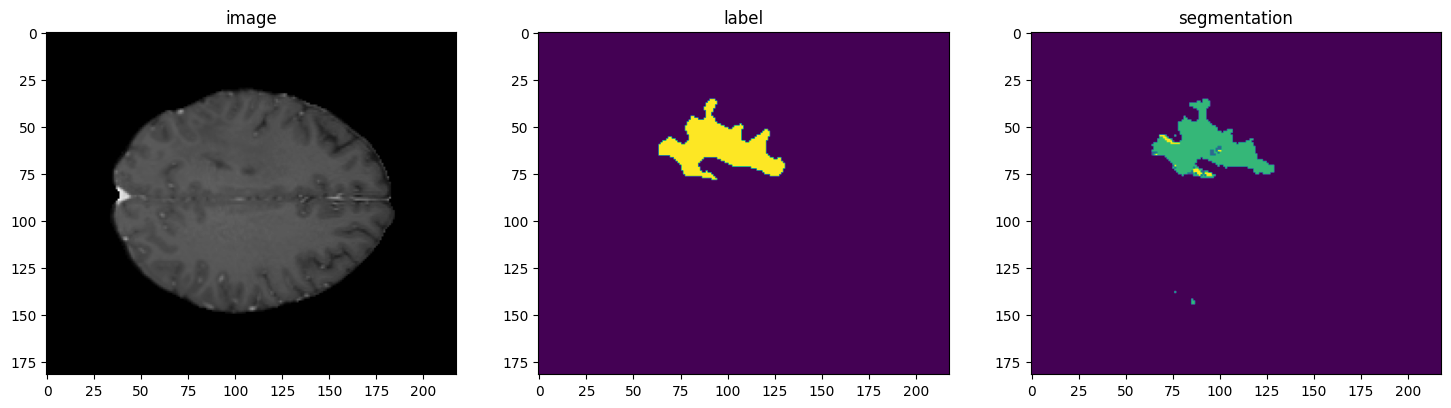

In [34]:
slice_num = 115

img_add = os.path.join("/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset/BraTS-GLI-02062-102/BraTS-GLI-02062-102-t1c.nii")

label_add = os.path.join("/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset/BraTS-GLI-02062-102/BraTS-GLI-02062-102-seg.nii")

img = nib.load(img_add).get_fdata()

label = nib.load(label_add).get_fdata()

plt.figure("image", (18, 6))

plt.subplot(1, 3, 1)

plt.title("image")

plt.imshow(img[:, :, slice_num], cmap="gray")

plt.subplot(1, 3, 2)

plt.title("label")

plt.imshow(label[:, :, slice_num])

plt.subplot(1, 3, 3)

plt.title("segmentation")

plt.imshow(seg_out[:, :, slice_num])

plt.show()

## Visualize segmentation output and compare with label

In [22]:
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[3]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 128)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[3]["image"][i, :, :, 64].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 4 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[3]["label"][i, :, :, 64].detach().cpu())
    plt.show()
    # visualize the 4 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 64].detach().cpu())
    plt.show()

NameError: name 'val_ds' is not defined